## Using word embeding to classify depression tweets
### Author: Ahmad Luqman Al Hakim bin Shamsudin

In this project, I obtained a dataset containing 1.6 million tweets that are pre-labelled depressed / not depressed. 

The main aim of my analysis is to classify the tweets into depressed / not depressed categories, and test the accuracy of the classifiers against the pre-labelled labels. Word embedding methods are used to train the classifiers.  

Link to Github repository: 

### 1. Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re

In [2]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer

In [3]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.10.0


### 2. Load and inspect dataset
The dataset comes with 1.6 million tweets, labelled as 0 for not depressed, and 4 for depressed. 

In [5]:
df = pd.read_csv('..\SA project\SA project_tweets scraped/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#inspect data
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


((1600000, 6), None)

In [7]:
#check zero values
np.sum(df.isnull().any(axis=1))

0

In [6]:
#assign names to columns
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
#drop unneeded columns to save space
df = df.drop(['id', 'query', 'user_id'], axis=1)

In [8]:
# change encoding of sentiment column, from 0 and 4, to 0 and 1
# original encoding: 0 is negative, 4 is positive 
# new encoding: 1 is depressed, 0 is non-depressed 
df['sentiment'] = df['sentiment'].map({0:1, 4:0})
df.head(5)

,sentiment,date,text
0,1,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,1,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,1,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,1,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

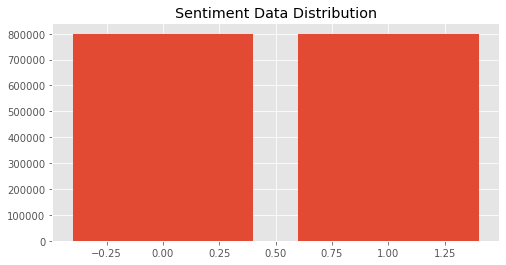

In [12]:
#check sentiment distribution 
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
# Storing data in lists.
#main dataset remains in df
text, sentiment, date = list(df['text']), list(df['sentiment']), list(df['date'])

In [10]:
#display tweets
with pd.option_context('display.max_colwidth', 5):
    display(text)

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarrison i wo

### 3. Data pre-processing. 
#### In this part, define a function that will perform all needed pre-processing procedures. Procedures performed are: lower casing the tweets, remove the URL's, replace emojis with texts, remove usernames, remove non-alphabet characters, remove repeating characters, remove stopwords, stemming and lemmatising the texts. 

In [9]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [10]:
#import stopwords list from nltk library
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [13]:
#tokenizer = RegexpTokenizer(r'\w+')
#df['text'] = df['text'].apply(tokenizer.tokenize)

In [11]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and stemmer
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Remove URL
        tweet = re.sub(urlPattern,' ',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Remove @USERNAME 
        tweet = re.sub(userPattern,' ', tweet)        
        # Remove all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwords:
                if len(word)>1:
                # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [14]:
#processedtext is kept in a separate list
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')

Text Preprocessing complete.


In [15]:
#add processed_text as a column in df 
df['processed_text'] = processedtext

In [16]:
df.head()

,sentiment,date,text,processed_text
0,1,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda got david carr third day EM...
1,1,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,1,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
3,1,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,1,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [22]:
#save processed df in csv to skip all previous steps
df.to_csv(path_or_buf='..\SA project\SA project_tweets scraped\df.csv')

In [6]:
#load processed dataframe, all previous steps can be skipped 
df = pd.read_csv('..\SA project\SA project_tweets scraped/df.csv', encoding = 'latin',header=0, index_col=0)

In [7]:
df.head()

,sentiment,date,text,processed_text
0,1,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda got david carr third day EM...
1,1,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,1,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
3,1,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,1,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",behaving mad see


### 4. Data visualisation 
#### Visualise non-depressed and depressed word clouds

In [19]:
#for non-depressed tweets
data_pos = df[df['sentiment']==0]['processed_text'] 

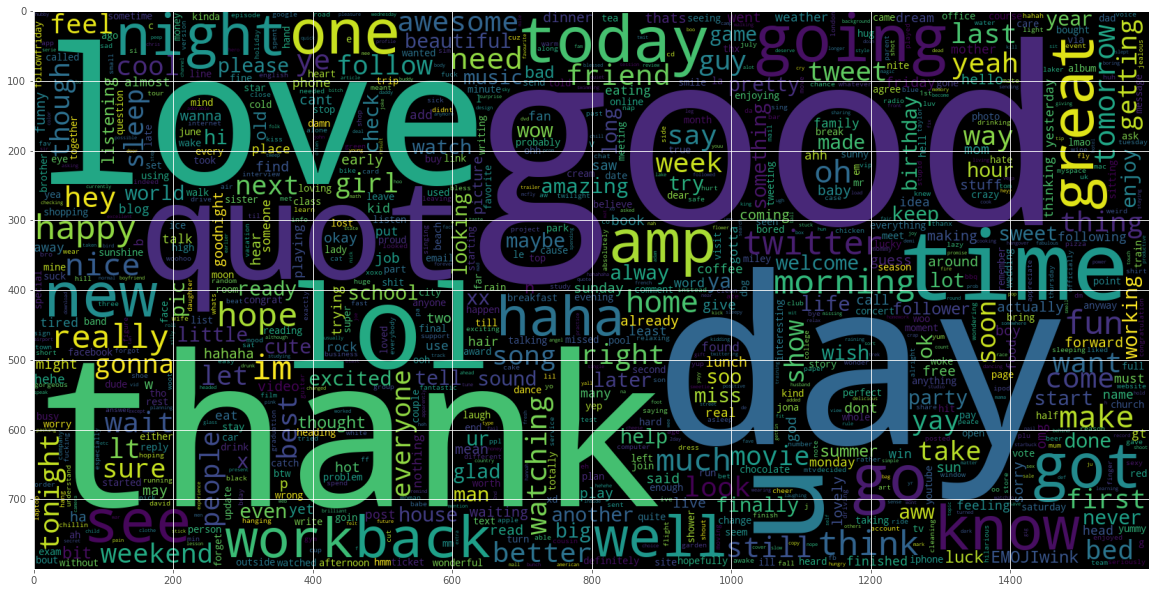

In [76]:
#non-depressed word cloud 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [77]:
data_neg = df[df['sentiment']==1]['processed_text'] 

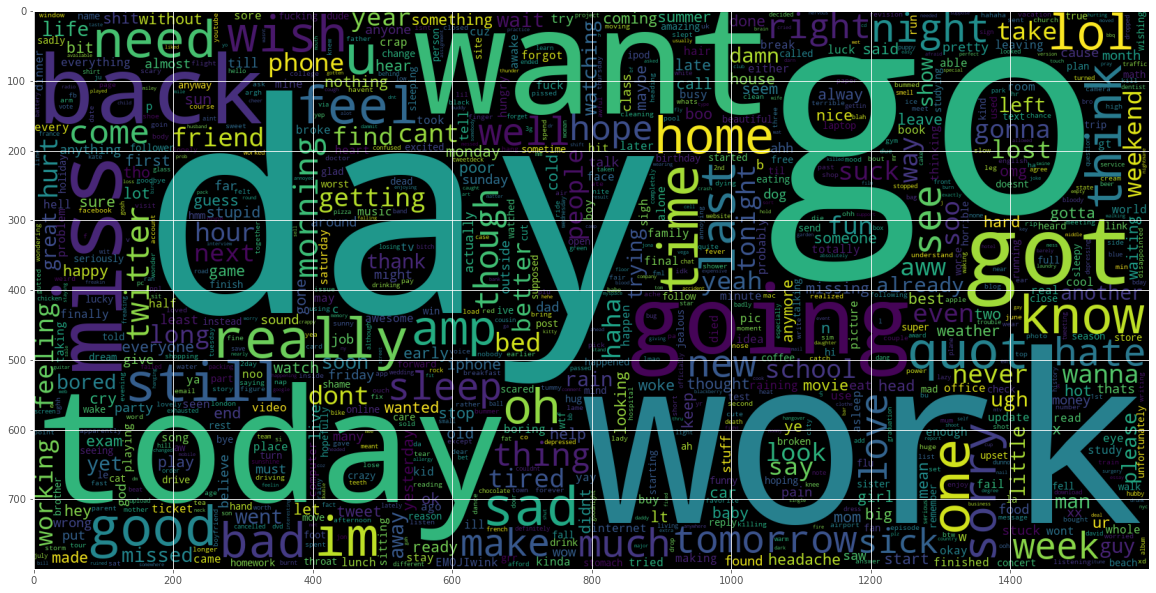

In [78]:
#depressed word cloud 
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### 5a. Benchmarking sentiment analysis using Textblob

Firstly, run the dataset through an off-the-shelf method to measure the polarity of the tweets. This is performed using textblob. Tweets that score below 0 are classified as 1 (depressed). And tweets that score above 0 are classified as 0 (non-depressed)

In [17]:
df.head()

,sentiment,date,text,processed_text
0,1,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda got david carr third day EM...
1,1,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,1,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
3,1,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,1,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [18]:
#textblob part
from textblob import TextBlob

In [19]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

df['textblob_polarity'] = df['processed_text'].apply(sentiment_calc)

In [20]:
#in textblob_sentiment column, (x,y) represents (polarity, subjectivity)
#if polarity is negative, convert to 1 (depressed tweets)
#if polarity is positive, convert to 0 (non-depressed)
df['textblob_sentiment'] =df['textblob_polarity'].map(lambda x: 1 if x < 0 else 0)

In [21]:
df.head()

,sentiment,date,text,processed_text,textblob_polarity,textblob_sentiment
0,1,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda got david carr third day EM...,0.150,0
1,1,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,0.000,0
2,1,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...,0.500,0
3,1,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,whole body feel itchy like fire,0.200,0
4,1,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",behaving mad see,-0.625,1


In [25]:
#measure accuracy of textblob 
(df['sentiment'] == df['textblob_sentiment']).value_counts()

True     961820
False    638180
dtype: int64

In [26]:
textblob_accuracy = (961820/1600000)*100
textblob_accuracy

60.113749999999996

Textblob predicts whether the tweet is positive or negative with 60.11% accuracy. This is used as the baseline model, which will be compared to Word2Vec model later on.

### 5b. Neural Networks, Word2Vec with LSTM 
For Word2Vec, the dataset is analysed using 2 models. cbow vs skip-gram based

In [17]:
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
df['processed_text'] = [[item,*item.split(' ')] for item in processedtext]

In [19]:
#dataset splitting
#set test size to 0.3
X_data, y_data = np.array(df['processed_text']), np.array(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.3, random_state = 777)
len(X_train), len(X_test), len(y_train), len(y_test)

(1120000, 480000, 1120000, 480000)

In [20]:
#word2vec training dataset 
word2vec_train_data = X_train 

In [21]:
#cbow based model defined 
word2vec_model = gensim.models.word2vec.Word2Vec(word2vec_train_data,vector_size = 100, sg=0, min_count = 5, workers = 6)

In [22]:
print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 41861


In [28]:
#word similarities 
word2vec_model.wv.most_similar('depression')

[('anxiety', 0.6708846688270569),
 ('separation', 0.6347039937973022),
 ('illness', 0.6050086617469788),
 ('detest', 0.5558192133903503),
 ('flare', 0.5542736649513245),
 ('redundancy', 0.5503567457199097),
 ('economic', 0.5468493700027466),
 ('statistic', 0.5434815287590027),
 ('traumatic', 0.5413870811462402),
 ('nausea', 0.5391903519630432)]

In [32]:
#tokenising - pre-padding 
#define input length 
input_length = 60
vocab_length = 60000
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [33]:
#padding X_train and X_test to input_length 
#padding to ensure that each tweet has the same number of token
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

In [34]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1120000, 60)
X_test.shape : (480000, 60)


In [35]:
#create embedding matrix 
#to be used as the embedding layer in RNN 
embedding_dimension = 100
embedding_matrix = np.zeros((vocab_length, embedding_dimension))

In [36]:
#embedding vocab is from tokenizer
#the word vectors are from word2vec model 
for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [37]:
#RNN with bi-LSTM 
#create a sequence model 
#embedding layer
#bidirectional
#lstm - rnn variant (do 1 model without this layer)
#conv1d
#globalmaxpool1d 
#dense 

def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = embedding_dimension,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [38]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [39]:
#RNN with bi-LSTM 
#create a sequence model 
#embedding layer
#this is the vanilla version 
#conv1d
#globalmaxpool1d 
#dense 

def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = embedding_dimension,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model2")
    return model

In [40]:
training_model2 = getModel()
training_model2.summary()

Model: "Sentiment_Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 100)           50100     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,051,733
Trainable params: 51,733
Non-trainable params: 6,000,000
___________________________________

In [41]:
#train the model 
#model callbacks
#ReduceLROnPlateau - reduces learning rate whenever the gain in performance metric specified stops improving
#EarlyStopping - stops training when a monitored metric has stopped improving
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [42]:
#compile model 
#to define loss, metrics and optimiser
#loss - binary crossentropy since dependent variable is binary
#metrics - accuracy to be monitored
#optimiser - Adam, which is for gradient descent
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
#for vanilla model
training_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
#train model 1 in history_1 

history_1 = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks, 
    verbose=1,
)


Epoch 1/12
985/985 [==============================] - 620s 620ms/step - loss: 0.4861 - accuracy: 0.7626 - val_loss: 0.4599 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 2/12
985/985 [==============================] - 588s 597ms/step - loss: 0.4639 - accuracy: 0.7771 - val_loss: 0.4491 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 3/12
985/985 [==============================] - 590s 599ms/step - loss: 0.4554 - accuracy: 0.7821 - val_loss: 0.4444 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 4/12
985/985 [==============================] - 589s 598ms/step - loss: 0.4496 - accuracy: 0.7857 - val_loss: 0.4400 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 5/12
985/985 [==============================] - 590s 599ms/step - loss: 0.4454 - accuracy: 0.7879 - val_loss: 0.4380 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 6/12
985/985 [==============================] - 595s 604ms/step - loss: 0.4417 - accuracy: 0.7907 - val_loss: 0.4351 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 7/12
985/985 [==========================

In [44]:
#for vanilla model 
history_2 = training_model2.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks, 
    verbose=1,
)


Epoch 1/12
985/985 [==============================] - 186s 183ms/step - loss: 0.4893 - accuracy: 0.7601 - val_loss: 0.4695 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 2/12
985/985 [==============================] - 63s 64ms/step - loss: 0.4627 - accuracy: 0.7774 - val_loss: 0.4640 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 3/12
985/985 [==============================] - 61s 62ms/step - loss: 0.4537 - accuracy: 0.7827 - val_loss: 0.4623 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 4/12
985/985 [==============================] - 61s 62ms/step - loss: 0.4476 - accuracy: 0.7865 - val_loss: 0.4610 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 5/12
985/985 [==============================] - 61s 62ms/step - loss: 0.4429 - accuracy: 0.7893 - val_loss: 0.4626 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 6/12
985/985 [==============================] - 59s 60ms/step - loss: 0.4387 - accuracy: 0.7917 - val_loss: 0.4631 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 7/12
985/985 [==============================] - 60

### 6. Evaluate model

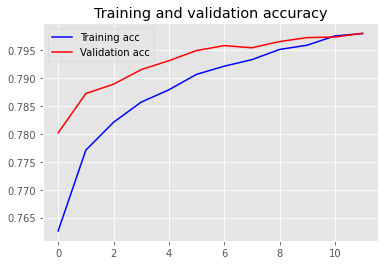

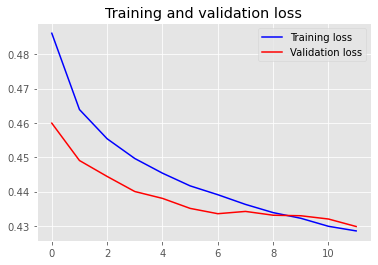

In [40]:
#evaluate model 
#print learning curve 
acc,  val_acc  = history_1.history['accuracy'], history_1.history['val_accuracy']
loss, val_loss = history_1.history['loss'], history_1.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

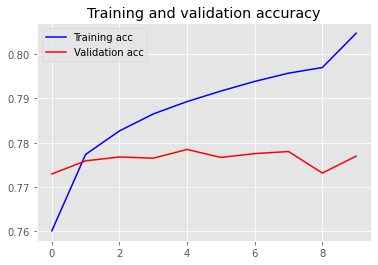

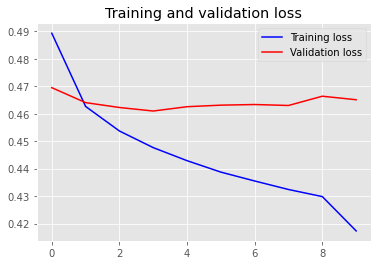

In [45]:
#vanilla model 
#evaluate model 
#print learning curve 
acc,  val_acc  = history_2.history['accuracy'], history_2.history['val_accuracy']
loss, val_loss = history_2.history['loss'], history_2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
#plot confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

15000/15000 [==============================] - 233s 15ms/step


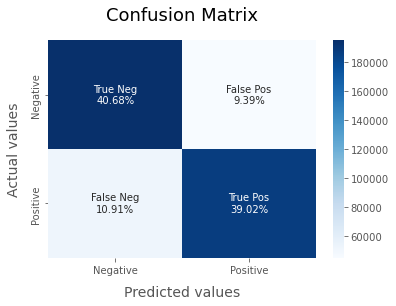

In [42]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [43]:
#classification report 
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80    240334
           1       0.81      0.78      0.79    239666

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000



### 7. Neural Networks, GloVe with LSTM

### 8. Save model for later use

In [60]:
import pickle

In [61]:
#save model in 2 different formats 
#keyedvectors
#full word2vec model
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")

INFO:tensorflow:Assets written to: Sentiment-BiLSTM\assets


INFO:tensorflow:Assets written to: Sentiment-BiLSTM\assets
